In [1]:
!pip install -U spacy


In [2]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 12.9 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt

In [3]:
print("ere")

ere


## Some boilerplate code for nicer looking confusion matrices


abridged from [scikit-learn example code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Some helper code to analyze TFIDF data

Credit for code goes to [buhrmann.github.io](https://buhrmann.github.io/tfidf-analysis.html)

In [5]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

# Load Data

In [6]:
corpus_fpath = 'ldsi_w21_curated_annotations_v1.json'
data = json.load(open(corpus_fpath))

In [7]:
data.keys()

dict_keys(['documents', 'annotations', 'types'])

In [8]:
data['documents'][0].keys()

dict_keys(['_id', 'name', 'plainText'])

In [9]:
#data['documents'][0]
# "id" refers to the MongoDB Gloss id of the document

In [10]:
data['annotations'][0]

{'_id': '61bb066d97ad59b4cfc4699a',
 'start': 15922,
 'end': 16078,
 'document': '61aea57397ad59b4cfc41399',
 'type': '61aeaf8097ad59b4cfc416d7'}

In [11]:
data['types'][0]
# all types have a 'isA' attribute which is an internal type-system 
# ontology used by Gloss for types and subtypes
# "attributes" can be ignored

{'_id': '61aeaf8097ad59b4cfc416d7',
 'name': 'CaseFooter',
 'isA': '58781cf945f90f3bfc5cba7d',
 'attributes': []}

In [12]:
len(data['documents'])

540

Define some convenience shorthands and dictionaries:

In [13]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}

# Data Structures

Examine data structures so we know how to work with them

In [14]:
annotations[0]

{'_id': '61bb066d97ad59b4cfc4699a',
 'start': 15922,
 'end': 16078,
 'document': '61aea57397ad59b4cfc41399',
 'type': '61aeaf8097ad59b4cfc416d7'}

In [15]:
list(types_by_id.items())[0]

('61aeaf8097ad59b4cfc416d7',
 {'_id': '61aeaf8097ad59b4cfc416d7',
  'name': 'CaseFooter',
  'isA': '58781cf945f90f3bfc5cba7d',
  'attributes': []})

In [16]:
list(documents_by_id.items())[0]

('61aea55c97ad59b4cfc4128c',
 {'_id': '61aea55c97ad59b4cfc4128c',
  'name': '0601461.txt',
  'plainText': 'Citation Nr: 0601461\t\r\nDecision Date: 01/18/06    Archive Date: 01/31/06\r\n\r\nDOCKET NO.  04-17 231\t)\tDATE\r\n\t)\r\n\t)\r\n\r\nOn appeal from the\r\nDepartment of Veterans Affairs Regional Office in No. Little \r\nRock, Arkansas\r\n\r\n\r\nTHE ISSUE\r\n\r\nEntitlement to service connection for hepatitis C.\r\n\r\n\r\nREPRESENTATION\r\n\r\nAppellant represented by:\tThe American Legion\r\n\r\n\r\nWITNESS AT HEARING ON APPEAL\r\n\r\nAppellant\r\n\r\n\r\nATTORNEY FOR THE BOARD\r\n\r\nP. Olson, Associate Counsel\r\n\r\n\r\nINTRODUCTION\r\n\r\nThe veteran had active military service from May 1971 to July \r\n1976.\r\n\r\nThis matter comes before the Board of Veterans\' Appeals \r\n(Board or BVA) on appeal from a July 2003 rating decision of \r\nthe Department of Veterans Affairs (VA) Regional Office (RO) \r\nin N. Little Rock, Arkansas.\r\n\r\nIn August 2004, the veteran testif

# Very Basic Data Survey

In [17]:
len(documents_by_id)

540

In [18]:
len(annotations)

22426

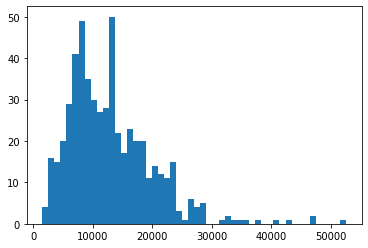

In [19]:
doc_lengths = [len(d['plainText']) for d in documents_by_id.values()]
plt.hist(doc_lengths, bins=50)
plt.show()

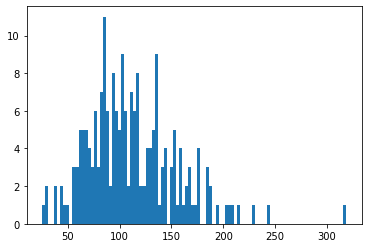

In [20]:
doc_num_annos = [len([a for a in annotations if a['document'] == doc_id])
                 for doc_id in documents_by_id]
doc_num_annos = [n for n in doc_num_annos if n > 0]
plt.hist(doc_num_annos, bins=100)
plt.show()

# Create Corpus

In [21]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations):
    span_data = []
    for a in annotations:
        start = a['start']
        end = a['end']
        document_txt = documents_by_id[a['document']]['plainText']
        atype = a['type']
        sd = {'txt': document_txt[start:end],
              'document': a['document'],
              'type': types_by_id[atype]['name'],
              'start': a['start'],
              'start_normalized': a['start'] / len(document_txt),
              # Results in a value between 0 and 1, which indicates where 
              # within the case text the sentence appears, i.e., a sentence
              # with 'start_normalized'=0.1 would be in the start, and one
              # with '0.9' will be near the end.
              'end': a['end']}
        span_data.append(sd)
    return span_data

In [22]:
spans = make_span_data(documents_by_id, types_by_id, annotations)
span_labels = [s['type'] for s in spans]

In [23]:
spans

[{'txt': "____________________________________________\r\nDEBORAH W. SINGLETON\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\n\r\n Department of Veterans Affairs\r",
  'document': '61aea57397ad59b4cfc41399',
  'type': 'CaseFooter',
  'start': 15922,
  'start_normalized': 0.9899894298327426,
  'end': 16078},
 {'txt': 'THE ISSUE\r',
  'document': '61aea57397ad59b4cfc41399',
  'type': 'Header',
  'start': 215,
  'start_normalized': 0.013368152707828141,
  'end': 225},
 {'txt': 'REPRESENTATION',
  'document': '61aea57397ad59b4cfc41399',
  'type': 'Header',
  'start': 312,
  'start_normalized': 0.019399365789964557,
  'end': 326},
 {'txt': 'ATTORNEY FOR THE BOARD\r',
  'document': '61aea57397ad59b4cfc41399',
  'type': 'Header',
  'start': 386,
  'start_normalized': 0.02400049741963564,
  'end': 409},
 {'txt': 'INTRODUCTION',
  'document': '61aea57397ad59b4cfc41399',
  'type': 'Header',
  'start': 445,
  'start_normalized': 0.027668967232481502,
  'end': 457},
 {'txt': 'FIN

In [24]:
print(span_labels)

['CaseFooter', 'Header', 'Header', 'Header', 'Header', 'Header', 'Header', 'Header', 'Header', 'Header', 'CaseHeader', 'Procedure', 'CaseIssue', 'Procedure', 'Procedure', 'Procedure', 'Procedure', 'ConclusionOfLaw', 'Citation', 'EvidenceBasedOrIntermediateFinding', 'LegalRule', 'ConclusionOfLaw', 'LegislationAndPolicy', 'LegislationAndPolicy', 'LegalRule', 'Citation', 'LegalRule', 'Citation', 'LegalRule', 'Citation', 'Evidence', 'Evidence', 'Evidence', 'EvidenceBasedReasoning', 'Evidence', 'EvidenceBasedReasoning', 'LegalRule', 'Citation', 'LegalRule', 'Citation', 'Evidence', 'Evidence', 'Evidence', 'EvidenceBasedOrIntermediateFinding', 'LegalRule', 'PolicyBasedReasoning', 'LegislationAndPolicy', 'LegalRule', 'Citation', 'LegalRule', 'Citation', 'EvidenceBasedReasoning', 'EvidenceBasedOrIntermediateFinding', 'Citation', 'EvidenceBasedReasoning', 'EvidenceBasedReasoning', 'EvidenceBasedReasoning', 'EvidenceBasedReasoning', 'EvidenceBasedReasoning', 'EvidenceBasedReasoning', 'EvidenceBas

In [25]:
print(len(spans))

22426


Sample train and test set while stratifying across types.  
Proportion of types in the test set should be the same as in the full dataset. (That's what stratification means)  
Making use of scikitlearns' trian-test split function

In [26]:
train_spans, test_spans = model_selection.train_test_split(spans,
                                                           test_size=.2,
                                                           random_state=42,
                                                           stratify=span_labels)
train_spans_txt = [s['txt'] for s in train_spans]
test_spans_txt = [s['txt'] for s in test_spans]

In [27]:
train_spans

[{'txt': 'Degenerative disc disease of the cervical spine was not incurred in active service, to include as due to a service-connected disability, nor may arthritis of the cervical spine be presumed to have been caused or aggravated by service.',
  'document': '61aea57497ad59b4cfc413f2',
  'type': 'ConclusionOfLaw',
  'start': 2990,
  'start_normalized': 0.07894597877171675,
  'end': 3224},
 {'txt': "In this case, however, the nature of the Veteran's back injury and resulting disability is not as clear as the immediately observable cause-and-effect relationship described in the case above and, as such, the Veteran's competence to address etiology is questionable.",
  'document': '61aea55d97ad59b4cfc412c7',
  'type': 'EvidenceBasedOrIntermediateFinding',
  'start': 6410,
  'start_normalized': 0.7256877618023322,
  'end': 6677},
 {'txt': 'Quartuccio, 16 Vet. App. at 187.',
  'document': '61aea55c97ad59b4cfc4129f',
  'type': 'Citation',
  'start': 3724,
  'start_normalized': 0.13149253204

In [28]:
train_spans_txt

['Degenerative disc disease of the cervical spine was not incurred in active service, to include as due to a service-connected disability, nor may arthritis of the cervical spine be presumed to have been caused or aggravated by service.',
 "In this case, however, the nature of the Veteran's back injury and resulting disability is not as clear as the immediately observable cause-and-effect relationship described in the case above and, as such, the Veteran's competence to address etiology is questionable.",
 'Quartuccio, 16 Vet. App. at 187.',
 'VA treatment records show complaints of chronic low back pain.',
 'In addition, in a January 2004 letter, the RO notified the \r\nveteran of the evidence needed to substantiate his claim, and \r\noffered to assist him in obtaining any relevant evidence, and \r\nrequested that he submit any additional evidence.',
 'The Board has the authority to "discount the weight and \r\nprobity of evidence in the light of its own inherent \r\ncharacteristics a

In [29]:
print(len(train_spans))
print(len(test_spans))

17940
4486


In [30]:
train_spans[0]

{'txt': 'Degenerative disc disease of the cervical spine was not incurred in active service, to include as due to a service-connected disability, nor may arthritis of the cervical spine be presumed to have been caused or aggravated by service.',
 'document': '61aea57497ad59b4cfc413f2',
 'type': 'ConclusionOfLaw',
 'start': 2990,
 'start_normalized': 0.07894597877171675,
 'end': 3224}

In [45]:
train_spans_txt[0]

'Degenerative disc disease of the cervical spine was not incurred in active service, to include as due to a service-connected disability, nor may arthritis of the cervical spine be presumed to have been caused or aggravated by service.'

In [46]:
print(f'train: {len(train_spans)}; test: {len(test_spans)}')

train: 17940; test: 4486


In [47]:
random.choice(train_spans)

{'txt': 'The Board acknowledges the Veterans Claims Assistance Act of \r\n2000 (VCAA).',
 'document': '61aea57397ad59b4cfc4139e',
 'type': 'LegislationAndPolicy',
 'start': 2840,
 'start_normalized': 0.1450978388596536,
 'end': 2915}

# Some Tough Examples

In [48]:
example_basic_1 = 'In sum, as the preponderance of the evidence is against the Veteran\'s claim, his appeal must be denied.'
example_cit_1 = 'Smith v. Gober, 14 Vet. App. 227 (2000), aff\'d 281 F.3d 1384 (Fed. Cir. 2002); Dela Cruz v. Principi, 15 Vet. App. 143 (2001); see also Quartuccio v. Principi, 16 Vet. App. 183 (2002).'
example_rule_1 = '"To establish a right to compensation for a present disability, a Veteran must show: "(1) the existence of a present disability; (2) in-service incurrence or aggravation of a disease or injury; and (3) a causal relationship between the present disability and the disease or injury incurred or aggravated during service"-the so-called "nexus" requirement."'
example_mixed_1 = 'In Dingess v. Nicholson, 19 Vet. App. 473 (2006), the U.S. Court of Appeals for Veterans Claims held that, upon receipt of an application for a service-connection claim, 38 U.S.C.A. � 5103(a) and 38 C.F.R. � 3.159(b) require VA to provide the claimant with notice that a disability rating and an effective date for the award of benefits will be assigned if service connection is awarded. '

# Manual Tokenization Example

Chunk the data into words, and represent the presence or absence of these words in our sentences as feature vectors.

In [49]:
def tokenize(txt):
    dirty_tokens = re.split('\s+', txt)  # split words
    # remove all non-alphanumerics
    clean_tokens = [re.sub(r'\W', '', t).lower() 
                    for t in dirty_tokens]
    if '' in clean_tokens:  # remove empty tokens
        clean_tokens.remove('')
    return clean_tokens


def tokenize_spans(spans):
    for s in spans:
        s['tokens_manual'] = tokenize(s['txt'])
        
        
def build_vocabulary(spans):
    vocab_counts = {}
    for sd in spans:
        for t in tokenize(sd['txt']):
            if t in vocab_counts:
                vocab_counts[t] += 1
            else:
                vocab_counts[t] = 1
    return vocab_counts

We can use this basic tokenizer to do some surface statistics

In [50]:
tokenize(example_basic_1)

['in',
 'sum',
 'as',
 'the',
 'preponderance',
 'of',
 'the',
 'evidence',
 'is',
 'against',
 'the',
 'veterans',
 'claim',
 'his',
 'appeal',
 'must',
 'be',
 'denied']

In [51]:
tokenize_spans(train_spans)

In [52]:
train_spans[0]

{'txt': 'Degenerative disc disease of the cervical spine was not incurred in active service, to include as due to a service-connected disability, nor may arthritis of the cervical spine be presumed to have been caused or aggravated by service.',
 'document': '61aea57497ad59b4cfc413f2',
 'type': 'ConclusionOfLaw',
 'start': 2990,
 'start_normalized': 0.07894597877171675,
 'end': 3224,
 'tokens_manual': ['degenerative',
  'disc',
  'disease',
  'of',
  'the',
  'cervical',
  'spine',
  'was',
  'not',
  'incurred',
  'in',
  'active',
  'service',
  'to',
  'include',
  'as',
  'due',
  'to',
  'a',
  'serviceconnected',
  'disability',
  'nor',
  'may',
  'arthritis',
  'of',
  'the',
  'cervical',
  'spine',
  'be',
  'presumed',
  'to',
  'have',
  'been',
  'caused',
  'or',
  'aggravated',
  'by',
  'service']}

In [53]:
vocab_counts_manual = build_vocabulary(train_spans)
unique_tokens_manual = [token for token, count in vocab_counts_manual.items() 
                        if count == 1]

In [54]:
vocab_counts_manual

{'degenerative': 126,
 'disc': 99,
 'disease': 1466,
 'of': 12382,
 'the': 26810,
 'cervical': 221,
 'spine': 313,
 'was': 3742,
 'not': 3030,
 'incurred': 520,
 'in': 7807,
 'active': 758,
 'service': 5700,
 'to': 9662,
 'include': 328,
 'as': 2347,
 'due': 383,
 'a': 7982,
 'serviceconnected': 294,
 'disability': 1964,
 'nor': 116,
 'may': 1051,
 'arthritis': 119,
 'be': 1915,
 'presumed': 133,
 'have': 790,
 'been': 1122,
 'caused': 215,
 'or': 3575,
 'aggravated': 431,
 'by': 1931,
 'this': 1498,
 'case': 547,
 'however': 417,
 'nature': 74,
 'veterans': 3884,
 'back': 372,
 'injury': 942,
 'and': 8137,
 'resulting': 199,
 'is': 4632,
 'clear': 158,
 'immediately': 23,
 'observable': 26,
 'causeandeffect': 4,
 'relationship': 147,
 'described': 87,
 'above': 171,
 'such': 707,
 'competence': 10,
 'address': 73,
 'etiology': 116,
 'questionable': 4,
 'quartuccio': 61,
 '16': 117,
 'vet': 1609,
 'app': 1604,
 'at': 1444,
 '187': 24,
 'va': 2455,
 'treatment': 948,
 'records': 1137,
 

In [55]:
print(len(vocab_counts_manual))
print(vocab_counts_manual['afghanistan'])
print(len(unique_tokens_manual)) # tokens that appear only once
# even removing these words that appear only once will likely not affect
# performance on the test-set, since these words are so rare

10736
12
4220


In [56]:
print(unique_tokens_manual)

['featuring', 'journet', 'vargasgonzalez', 'delhauer', '1117d', 'asa', 'international', 'amedical', 'book', '14373', '11774', 'feasible', 'postrecords', 'keh', 'zig', 'zags', 'alleviation', 'worthwhile', 'fugere', '972', 'successive', 'interests', 'osteochondromatosis', 'cartilaginous', 'supracondylar', 'genital', '1601729', '011416', '0926', '949', '19751996', 'securing', '0947488', '121509', '122409', '0602', 'bupyong', 'generating', 'critically', 'arzio', '602', '490', '5758', 'specializing', 'nighttime', 'colloquy', 'substantiation', 'vasotec', 'upholding', 'internally', 'ring', 'interphalangeal', 'biologicalgenetic', 'oncologists', 'metpreponderance', 'rwh', 'destroying', '1112c3bi', 'torturous', 'arrival', 'standoff', 'disperse', 'viterna', 'precipitant', 'myelopathy', '1027866', '072610', '081010', '0016', '637', 'teleconference', 'hyson', '262', '15s', 'fingertips', 'threeweek', 'pneuomonitis', 'bronchopneumonia', 'marcinak', '198', 'dods', 'brown6', 'disrupted', '1137568', '10

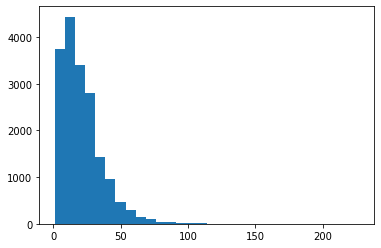

In [57]:
span_lengths_manual = [len(s['tokens_manual']) for s in train_spans]
plt.hist(span_lengths_manual, bins=30)
plt.show()

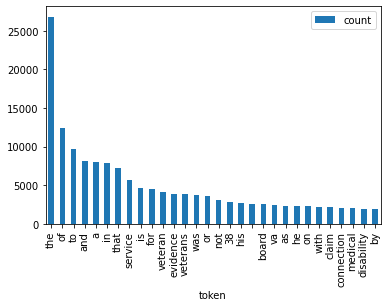

In [58]:
vocab_df = pd.DataFrame([{'token': t, 'count': c} for t, c in vocab_counts_manual.items()])
vocab_df = vocab_df.set_index(['token'])
vocab_df.sort_values('count', ascending=False)[:30].plot.bar()
plt.show()

In [59]:
min_freq = 15
max_freq = 4000
feature_names_manual = sorted(token for token, count in vocab_counts_manual.items() 
                       if min_freq <= count <= max_freq)
print(f'number of thresholded with {min_freq} < n < {max_freq}: {len(feature_names_manual)}')

number of thresholded with 15 < n < 4000: 1895


# Basic TFIDF vectorization with sklearn

We are using sklear's [TFIDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit) here, because it is faster than doing it all by ourselves and has useful default parameters

In [60]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer = vectorizer.fit(train_spans_txt)
tfidf_features_skl = vectorizer.get_feature_names()

In [61]:
train_spans_txt

['Degenerative disc disease of the cervical spine was not incurred in active service, to include as due to a service-connected disability, nor may arthritis of the cervical spine be presumed to have been caused or aggravated by service.',
 "In this case, however, the nature of the Veteran's back injury and resulting disability is not as clear as the immediately observable cause-and-effect relationship described in the case above and, as such, the Veteran's competence to address etiology is questionable.",
 'Quartuccio, 16 Vet. App. at 187.',
 'VA treatment records show complaints of chronic low back pain.',
 'In addition, in a January 2004 letter, the RO notified the \r\nveteran of the evidence needed to substantiate his claim, and \r\noffered to assist him in obtaining any relevant evidence, and \r\nrequested that he submit any additional evidence.',
 'The Board has the authority to "discount the weight and \r\nprobity of evidence in the light of its own inherent \r\ncharacteristics a

In [62]:
train_tfidf_skl = vectorizer.transform(train_spans_txt).toarray()
test_tfidf_skl = vectorizer.transform(test_spans_txt).toarray()
train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])

In [63]:
len(train_tfidf_skl)

17940

In [64]:
for t in train_spans_labels:
    print(t)

ConclusionOfLaw
EvidenceBasedOrIntermediateFinding
Citation
Evidence
Evidence
LegalRule
LegalRule
EvidenceBasedOrIntermediateFinding
ConclusionOfLaw
Citation
Citation
LegalRule
Citation
Citation
Header
Evidence
Procedure
LegalRule
Evidence
Evidence
LegalRule
EvidenceBasedOrIntermediateFinding
EvidenceBasedReasoning
Procedure
LegalRule
Evidence
EvidenceBasedOrIntermediateFinding
Evidence
Header
EvidenceBasedOrIntermediateFinding
Citation
Citation
LegalRule
Evidence
Header
LegalRule
Header
Citation
EvidenceBasedOrIntermediateFinding
LegalRule
Procedure
EvidenceBasedOrIntermediateFinding
Evidence
Procedure
Procedure
Citation
Procedure
Procedure
Evidence
Evidence
Evidence
Evidence
Evidence
Evidence
Evidence
Procedure
LegalRule
Evidence
Citation
EvidenceBasedReasoning
Evidence
Evidence
Header
Evidence
Procedure
Citation
EvidenceBasedOrIntermediateFinding
EvidenceBasedReasoning
Evidence
Procedure
Evidence
LegalRule
CaseIssue
EvidenceBasedOrIntermediateFinding
Evidence
Citation
Header
LegalRu

Procedure
Header
Evidence
LegalRule
ConclusionOfLaw
LegalRule
Evidence
Citation
LegalRule
EvidenceBasedOrIntermediateFinding
EvidenceBasedOrIntermediateFinding
LegalRule
EvidenceBasedReasoning
Evidence
Evidence
Evidence
Evidence
Procedure
EvidenceBasedOrIntermediateFinding
Evidence
Citation
Evidence
EvidenceBasedReasoning
Procedure
Header
Evidence
Procedure
Header
EvidenceBasedOrIntermediateFinding
LegalRule
EvidenceBasedOrIntermediateFinding
LegislationAndPolicy
Citation
Evidence
Header
Evidence
EvidenceBasedOrIntermediateFinding
CaseHeader
Evidence
Evidence
Evidence
EvidenceBasedReasoning
CaseIssue
EvidenceBasedReasoning
Evidence
LegislationAndPolicy
LegislationAndPolicy
EvidenceBasedReasoning
EvidenceBasedReasoning
Evidence
EvidenceBasedOrIntermediateFinding
EvidenceBasedOrIntermediateFinding
Evidence
Citation
Evidence
Procedure
EvidenceBasedOrIntermediateFinding
EvidenceBasedOrIntermediateFinding
Header
Procedure
Citation
Procedure
Evidence
Evidence
LegalRule
Header
EvidenceBasedRe

LegalRule
Citation
Procedure
Header
EvidenceBasedReasoning
EvidenceBasedOrIntermediateFinding
Header
Procedure
LegalRule
Header
Citation
Evidence
EvidenceBasedOrIntermediateFinding
Citation
Procedure
Header
ConclusionOfLaw
Evidence
Citation
Citation
Citation
Evidence
Evidence
Procedure
Citation
EvidenceBasedOrIntermediateFinding
LegalRule
Header
Evidence
Evidence
LegalRule
LegalRule
Evidence
EvidenceBasedReasoning
LegalRule
Procedure
Procedure
Citation
EvidenceBasedOrIntermediateFinding
Citation
Evidence
EvidenceBasedOrIntermediateFinding
LegislationAndPolicy
Evidence
LegalRule
Procedure
Evidence
Header
LegalRule
EvidenceBasedOrIntermediateFinding
LegalRule
Evidence
Citation
Citation
Header
ConclusionOfLaw
EvidenceBasedReasoning
LegislationAndPolicy
Evidence
Evidence
Evidence
Citation
Citation
Citation
Citation
LegalRule
LegalRule
Procedure
Evidence
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
Procedure
Procedure
Evidence
EvidenceBasedReasoning
Evidence
Header
Evidence
LegalRul

EvidenceBasedOrIntermediateFinding
Evidence
Citation
Citation
Evidence
Header
EvidenceBasedReasoning
Evidence
EvidenceBasedOrIntermediateFinding
Procedure
Header
EvidenceBasedReasoning
Evidence
LegalRule
LegalRule
EvidenceBasedOrIntermediateFinding
Evidence
EvidenceBasedReasoning
Evidence
Procedure
Evidence
Evidence
Evidence
Citation
EvidenceBasedOrIntermediateFinding
Citation
EvidenceBasedOrIntermediateFinding
Evidence
EvidenceBasedOrIntermediateFinding
Procedure
EvidenceBasedReasoning
Evidence
Citation
Procedure
LegalRule
EvidenceBasedOrIntermediateFinding
EvidenceBasedOrIntermediateFinding
EvidenceBasedReasoning
Evidence
Evidence
Evidence
Evidence
Header
ConclusionOfLaw
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
ConclusionOfLaw
Citation
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
Procedure
Procedure
Evidence
Citation
EvidenceBasedOrIntermediateFinding
Evidence
EvidenceBasedOrIntermediateFinding
Procedure
ConclusionOfLaw
Evidence
Procedure
Evidence
Evidence
Evidenc

EvidenceBasedReasoning
LegalRule
Evidence
EvidenceBasedReasoning
Evidence
EvidenceBasedOrIntermediateFinding
Header
EvidenceBasedOrIntermediateFinding
Header
EvidenceBasedOrIntermediateFinding
Procedure
EvidenceBasedOrIntermediateFinding
Citation
EvidenceBasedOrIntermediateFinding
EvidenceBasedReasoning
EvidenceBasedOrIntermediateFinding
Header
LegalRule
CaseHeader
Evidence
Evidence
Header
LegalRule
EvidenceBasedReasoning
EvidenceBasedReasoning
LegalRule
EvidenceBasedReasoning
EvidenceBasedOrIntermediateFinding
LegalRule
LegalRule
LegalRule
Evidence
LegalRule
Citation
Header
Evidence
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
Header
Citation
EvidenceBasedReasoning
Procedure
Procedure
LegalRule
Evidence
Evidence
LegalRule
Header
Evidence
EvidenceBasedOrIntermediateFinding
LegalRule
EvidenceBasedOrIntermediateFinding
Evidence
Evidence
Evidence
CaseHeader
Evidence
Citation
Procedure
LegalRule
Citation
Citation
LegalRule
Citation
Evidence
Procedure
Citation
LegalRule
Evidence
Evi

EvidenceBasedReasoning
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
EvidenceBasedOrIntermediateFinding
LegalRule
LegalRule
Evidence
Citation
Citation
Header
LegalRule
Evidence
EvidenceBasedReasoning
Citation
LegalRule
Header
Header
Procedure
LegalRule
Evidence
Header
Citation
Procedure
Evidence
Procedure
LegalRule
Evidence
Citation
Evidence
Citation
Citation
Procedure
Header
EvidenceBasedReasoning
EvidenceBasedReasoning
Header
Evidence
Evidence
Citation
Evidence
Evidence
Evidence
Citation
EvidenceBasedOrIntermediateFinding
Evidence
Evidence
Evidence
LegalRule
LegalRule
Procedure
EvidenceBasedOrIntermediateFinding
Header
EvidenceBasedReasoning
Procedure
Evidence
Evidence
Citation
Citation
Header
Citation
Evidence
Evidence
CaseIssue
EvidenceBasedOrIntermediateFinding
Citation
Citation
Evidence
CaseFooter
EvidenceBasedOrIntermediateFinding
Citation
EvidenceBasedOrIntermediateFinding
Header
Evidence
Procedure
LegalRule
Citation
Evidence
Procedure
Header
Citation
Evidence
LegalRule


Citation
Evidence
Header
Evidence
PolicyBasedReasoning
Evidence
Evidence
EvidenceBasedReasoning
Citation
Evidence
Evidence
Citation
EvidenceBasedOrIntermediateFinding
Evidence
LegalRule
EvidenceBasedReasoning
CaseHeader
Evidence
EvidenceBasedReasoning
EvidenceBasedReasoning
EvidenceBasedReasoning
Evidence
EvidenceBasedOrIntermediateFinding
ConclusionOfLaw
EvidenceBasedOrIntermediateFinding
Evidence
Header
Citation
Citation
Citation
Citation
ConclusionOfLaw
Header
EvidenceBasedOrIntermediateFinding
Citation
EvidenceBasedOrIntermediateFinding
Citation
Procedure
LegalRule
LegalRule
Evidence
Citation
Procedure
Citation
EvidenceBasedReasoning
Citation
LegalRule
Evidence
Evidence
Header
LegalRule
Header
Procedure
CaseHeader
Citation
EvidenceBasedOrIntermediateFinding
Procedure
Procedure
Citation
Citation
LegalRule
EvidenceBasedOrIntermediateFinding
Header
Citation
LegalRule
Header
Citation
EvidenceBasedOrIntermediateFinding
EvidenceBasedReasoning
Citation
Procedure
Evidence
Evidence
CaseIssu

Evidence
Evidence
Citation
Procedure
Procedure
Citation
Evidence
CaseFooter
Header
Header
ConclusionOfLaw
EvidenceBasedOrIntermediateFinding
Header
LegalRule
LegalRule
Header
Procedure
Evidence
LegalRule
EvidenceBasedOrIntermediateFinding
Procedure
Procedure
Evidence
EvidenceBasedOrIntermediateFinding
Evidence
Procedure
PolicyBasedReasoning
Evidence
Procedure
EvidenceBasedOrIntermediateFinding
Header
LegalRule
Evidence
EvidenceBasedReasoning
LegalRule
PolicyBasedReasoning
EvidenceBasedReasoning
LegalRule
Header
LegalRule
LegalRule
Procedure
Header
EvidenceBasedOrIntermediateFinding
Evidence
LegalRule
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
EvidenceBasedReasoning
Citation
Evidence
Procedure
EvidenceBasedReasoning
Procedure
Procedure
Procedure
LegalRule
Evidence
EvidenceBasedReasoning
Procedure
Citation
LegalRule
Procedure
Citation
Evidence
Evidence
Evidence
Citation
EvidenceBasedReasoning
Evidence
EvidenceBasedReasoning
EvidenceBasedOrIntermediateFinding
Citation
Conclusion

EvidenceBasedReasoning
Citation
Citation
ConclusionOfLaw
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
Header
Evidence
LegalRule
Evidence
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
Procedure
EvidenceBasedReasoning
Citation
Header
Procedure
Procedure
EvidenceBasedOrIntermediateFinding
EvidenceBasedReasoning
Evidence
LegalRule
LegalRule
Header
CaseHeader
EvidenceBasedOrIntermediateFinding
Citation
Procedure
EvidenceBasedOrIntermediateFinding
Header
Evidence
EvidenceBasedReasoning
Header
Citation
Citation
Evidence
Evidence
Citation
Evidence
CaseFooter
Evidence
Evidence
Evidence
Evidence
EvidenceBasedReasoning
Evidence
Header
Header
Procedure
CaseHeader
EvidenceBasedOrIntermediateFinding
Evidence
Evidence
Citation
EvidenceBasedOrIntermediateFinding
Evidence
Citation
LegalRule
Citation
EvidenceBasedOrIntermediateFinding
Evidence
EvidenceBasedOrIntermediateFinding
Header
EvidenceBasedOrIntermediateFinding
Citation
Procedure
CaseFooter
Header
Citation
EvidenceBasedOrIntermedi

EvidenceBasedReasoning
EvidenceBasedOrIntermediateFinding
Procedure
Citation
LegislationAndPolicy
Evidence
Citation
EvidenceBasedOrIntermediateFinding
EvidenceBasedOrIntermediateFinding
Evidence
Evidence
Citation
Procedure
EvidenceBasedReasoning
Evidence
EvidenceBasedOrIntermediateFinding
Evidence
Header
Evidence
Procedure
CaseHeader
Evidence
Evidence
ConclusionOfLaw
ConclusionOfLaw
Citation
Citation
Evidence
LegalRule
Evidence
EvidenceBasedOrIntermediateFinding
ConclusionOfLaw
EvidenceBasedOrIntermediateFinding
CaseFooter
Evidence
LegalRule
Header
Evidence
LegalRule
EvidenceBasedOrIntermediateFinding
Procedure
LegalRule
Citation
Procedure
Evidence
Evidence
Header
Citation
Header
Procedure
Procedure
Citation
ConclusionOfLaw
Procedure
LegalRule
Citation
Evidence
EvidenceBasedOrIntermediateFinding
Evidence
Header
CaseIssue
Evidence
ConclusionOfLaw
Evidence
Evidence
EvidenceBasedOrIntermediateFinding
Evidence
EvidenceBasedReasoning
Header
EvidenceBasedOrIntermediateFinding
Evidence
Citati

... and we get numpy arrays

In [65]:
train_tfidf_skl.shape

(17940, 3610)

In [66]:
print(train_tfidf_skl)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Examine the top TFIDF values of tokens in a sentence

In [67]:
span_top_tfidf(train_spans_txt, 
               train_tfidf_skl,
               tfidf_features_skl,
               random.randint(0, len(train_spans)))

span text:
 For these reasons, the Board finds that VA has fulfilled the duties to notify and assist the Veteran.

      feature     tfidf
0   fulfilled  0.443382
1      duties  0.330886
2      notify  0.307240
3     reasons  0.306804
4       these  0.300423
5      assist  0.289578
6       finds  0.268036
7         the  0.257874
8         has  0.205186
9          va  0.181984
10      board  0.178063
11        for  0.150940
12       that  0.131951
13        and  0.125983
14    veteran  0.125404


Examine features with highest average TFIDF score per class

In [68]:
dfs = top_features_by_class(train_tfidf_skl, 
                            train_spans_labels,
                            tfidf_features_skl)

In [69]:
dfs.keys()

dict_keys(['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation', 'ConclusionOfLaw', 'Evidence', 'EvidenceBasedOrIntermediateFinding', 'EvidenceBasedReasoning', 'Header', 'LegalRule', 'LegislationAndPolicy', 'PolicyBasedReasoning', 'Procedure', 'RemandInstructions'])

In [70]:
dfs['Citation']

,feature,tfidf
0,38,0.203400
1,see,0.091398
2,vet,0.090993
3,app,0.090912
4,303,0.080463
5,west,0.054738
6,2002,0.039421
7,1110,0.037780
8,159,0.036896
9,brown,0.035819


## Train & Evaluate Model

Models:  
[Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)  
[Support Vector Machine Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
[Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  
[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [71]:
#clf_skl = SVC(gamma='auto')
#clf_skl = RandomForestClassifier(n_estimators=100, max_depth=12)
clf_skl = tree.DecisionTreeClassifier(max_depth=20)
#clf_skl = GaussianNB()
clf_skl = clf_skl.fit(train_tfidf_skl, train_spans_labels)

In [72]:
print('TRAIN:\n'+classification_report(train_spans_labels, 
                                       clf_skl.predict(train_tfidf_skl)))
print('TEST:\n'+classification_report(test_spans_labels,
                                      clf_skl.predict(test_tfidf_skl)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       160
                        CaseHeader       1.00      0.98      0.99       163
                         CaseIssue       0.98      0.92      0.95       173
                          Citation       1.00      0.98      0.99      2899
                   ConclusionOfLaw       0.96      0.90      0.93       398
                          Evidence       0.76      0.94      0.84      5143
EvidenceBasedOrIntermediateFinding       0.85      0.65      0.73      1793
            EvidenceBasedReasoning       0.77      0.46      0.57      1144
                            Header       0.89      0.99      0.93      1702
                         LegalRule       0.84      0.86      0.85      2304
              LegislationAndPolicy       0.88      0.44      0.58       217
              PolicyBasedReasoning       1.00      0.24      0.38        42
    

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

# Build Feature Vector using Spacy
More information: [Spacy](https://spacy.io)

## Tokenization

In [73]:
# basic English pipeline provided by spacy
nlp = spacy.load("en_core_web_sm")

More information on customizing tokenizers [at the Spacy docs](https://spacy.io/usage/linguistic-features#tokenization)  
Note that you may not alter the text, but you can use it to suppress or force tokenization.

In [74]:
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])

In [75]:
#test_txt = example_basic_1
#test_txt = example_cit_1
#test_txt = example_mixed_1
#print(test_txt)
example_cit_1 = 'Smith v. Gober, 14 Vet. App. 227 (2000), aff\'d 281 F.3d 1384 (Fed. Cir. 2002); Dela Cruz v. Principi, 15 Vet. App. 143 (2001); see also Quartuccio v. Principi, 16 Vet. App. 183 (2002).'

doc = nlp(example_cit_1)
print(f'{len(list(doc.sents))} sentences:')
print('===')
for sent in doc.sents:
    print(sent)
print('===')
for t in doc:
    print(f'{t.text} | {t.lemma_} | {t.pos_}')

2 sentences:
===
Smith v. Gober, 14 Vet. App. 227 (2000), aff'd 281 F.3d 1384
(Fed. Cir. 2002); Dela Cruz v. Principi, 15 Vet. App. 143 (2001); see also Quartuccio v. Principi, 16 Vet. App. 183 (2002).
===
Smith | Smith | PROPN
v. | v. | ADP
Gober | Gober | PROPN
, | , | PUNCT
14 | 14 | NUM
Vet. App. | Vet. App. | PROPN
227 | 227 | NUM
( | ( | PUNCT
2000 | 2000 | NUM
) | ) | PUNCT
, | , | PUNCT
aff'd | aff'd | VERB
281 | 281 | NUM
F.3d | F.3d | PROPN
1384 | 1384 | NUM
( | ( | PUNCT
Fed | Fed | PROPN
. | . | PUNCT
Cir | Cir | PROPN
. | . | PROPN
2002 | 2002 | NUM
) | ) | PUNCT
; | ; | PUNCT
Dela | Dela | PROPN
Cruz | Cruz | PROPN
v. | v. | CCONJ
Principi | Principi | PROPN
, | , | PUNCT
15 | 15 | NUM
Vet. App. | vet. app. | NOUN
143 | 143 | NUM
( | ( | PUNCT
2001 | 2001 | NUM
) | ) | PUNCT
; | ; | PUNCT
see | see | VERB
also | also | ADV
Quartuccio | Quartuccio | PROPN
v. | v. | CCONJ
Principi | Principi | PROPN
, | , | PUNCT
16 | 16 | NUM
Vet. App. | Vet. App. | PROPN
183 | 183 | NUM
(

In [76]:
def spacy_tokenize(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            clean_tokens.append(t.lemma_)
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [77]:
# will take a moment
spans_add_spacy_tokens(train_spans)
spans_add_spacy_tokens(test_spans)

In [78]:
random.choice(train_spans)

{'txt': "In a June \r\n2005 supplemental statement of the case, the RO in Manila \r\nreopened the veteran's service connection claim for an eye \r\ndisorder, but denied the claim on the merits.",
 'document': '61aea57197ad59b4cfc4136e',
 'type': 'Procedure',
 'start': 1256,
 'start_normalized': 0.05518938395289569,
 'end': 1434,
 'tokens_manual': ['in',
  'a',
  'june',
  '2005',
  'supplemental',
  'statement',
  'of',
  'the',
  'case',
  'the',
  'ro',
  'in',
  'manila',
  'reopened',
  'the',
  'veterans',
  'service',
  'connection',
  'claim',
  'for',
  'an',
  'eye',
  'disorder',
  'but',
  'denied',
  'the',
  'claim',
  'on',
  'the',
  'merits'],
 'tokens_spacy': ['in',
  'a',
  'June',
  '\r\n',
  '<NUM4>',
  'supplemental',
  'statement',
  'of',
  'the',
  'case',
  'the',
  'ro',
  'in',
  'Manila',
  '\r\n',
  'reopen',
  'the',
  'veteran',
  "'s",
  'service',
  'connection',
  'claim',
  'for',
  'an',
  'eye',
  '\r\n',
  'disorder',
  'but',
  'deny',
  'the',
  

## Vectorization

In [79]:
# suboptimal: tokenizer gets called twice
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,1))
spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)
tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names()

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [80]:
train_spans_txt[0]

'Degenerative disc disease of the cervical spine was not incurred in active service, to include as due to a service-connected disability, nor may arthritis of the cervical spine be presumed to have been caused or aggravated by service.'

### Small walkthrough of how to extend/compose feature vectors

In [81]:
len(train_spans_txt)

17940

In [82]:
# numpy feature vector extension
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()
print(train_tfidf_spacy.shape)
train_starts_normalized = np.array([s['start_normalized'] for s in train_spans])
print(train_starts_normalized.shape)
print(np.expand_dims(train_starts_normalized, axis=1).shape)
ext = np.concatenate((train_tfidf_spacy, 
                      np.expand_dims(train_starts_normalized, axis=1)), axis=1)
print(ext.shape)

(17940, 3682)
(17940,)
(17940, 1)
(17940, 3683)


In [83]:
len(train_tfidf_spacy[0])

3682

### Examine highest average TFIDF features by class

In [84]:
dfs = top_features_by_class(train_tfidf_spacy, train_spans_labels, tfidf_features_spacy)

In [85]:
dfs['Citation']

,feature,tfidf
0,<NUM2>,0.215069
1,�,0.209088
2,<NUM4>,0.201451
3,<NUM3>,0.136086
4,c.f.r,0.112568
5,v.,0.104778
6,.,0.095248
7,vet,0.094391
8,app,0.094249
9,see,0.090357


In [86]:
spans[88]['txt']

'In addition, \r\nhe did not specify the approximate location in Vietnam where \r\nthese alleged deaths occurred.\r'

In [102]:
spans[88].keys()

dict_keys(['txt', 'document', 'type', 'start', 'start_normalized', 'end', 'tokens_manual', 'tokens_spacy'])

In [103]:
def make_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1)), axis=1)
    print(X.shape)
    return X, y

In [92]:
train_X, train_y = make_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
test_X, test_y = make_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

In [93]:
print(f'{train_X.shape} {train_y.shape}')
print(f'{test_X.shape} {test_y.shape}')

(17940, 3683) (17940,)
(4486, 3683) (4486,)


In [94]:
#clf = GaussianNB()
clf = tree.DecisionTreeClassifier(max_depth=16)
clf = clf.fit(train_X, train_y)

In [95]:
train_spans_labels

array(['ConclusionOfLaw', 'EvidenceBasedOrIntermediateFinding',
       'Citation', ..., 'Evidence', 'Evidence', 'Evidence'], dtype='<U34')

In [ ]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('TEST:\n'+classification_report(test_spans_labels, clf.predict(test_X)))

In [ ]:
test_spans_labels.shape

In [ ]:
type(test_spans_labels)

In [ ]:
test_X.shape

In [171]:
type(test_X)

numpy.ndarray

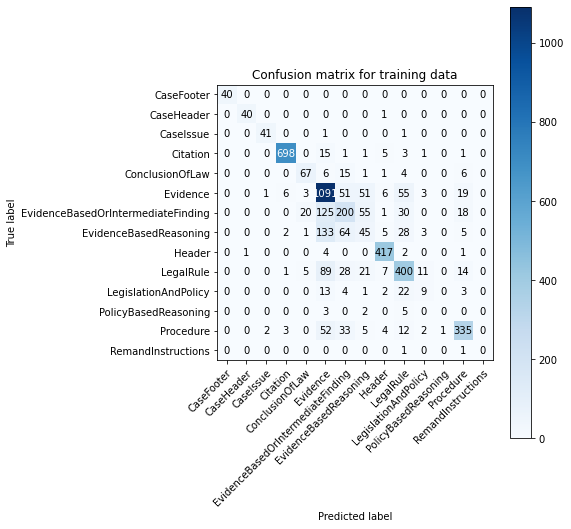

In [172]:
plot_confusion_matrix(test_spans_labels, clf.predict(test_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

In [107]:
type_names_by_id

{'61aeaf8097ad59b4cfc416d7': 'CaseFooter',
 '61aeaf8f97ad59b4cfc416d8': 'CaseHeader',
 '61aeaf9b97ad59b4cfc416d9': 'CaseIssue',
 '61aeafe297ad59b4cfc416da': 'Citation',
 '61aeafed97ad59b4cfc416db': 'ConclusionOfLaw',
 '61aeb00b97ad59b4cfc416dc': 'Evidence',
 '61aeb07c97ad59b4cfc416de': 'EvidenceBasedOrIntermediateFinding',
 '61aeb09097ad59b4cfc416df': 'EvidenceBasedReasoning',
 '61aeb0a497ad59b4cfc416e0': 'Header',
 '61aeb0d497ad59b4cfc416e1': 'LegislationAndPolicy',
 '61aeb19697ad59b4cfc416e3': 'Procedure',
 '61aeb1a297ad59b4cfc416e4': 'RemandInstructions',
 '61b20e3897ad59b4cfc41c04': 'LegalRule',
 '61b2315297ad59b4cfc42545': 'PolicyBasedReasoning'}

In [44]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [39]:
len(train_spans)

17940

In [42]:
train_spans[0].keys()

dict_keys(['txt', 'document', 'type', 'start', 'start_normalized', 'end'])

In [104]:
prediction_errors(clf,
                  random.sample(train_spans, 40),
                  spacy_tfidf_vectorizer,
                  select_pred_label='Evidence')

(40, 3683)
sentence # 0 / case 0813412.txt / @17241
pred: Evidence / true: EvidenceBasedReasoning
The veteran's claims folder contains voluminous 
amounts of material signed by the doctor and not one of those 
documents contradicts her statement made to the VA.

sentence # 14 / case 1429023.txt / @6554
pred: Evidence / true: Header
III.  Merits of the Claim

sentence # 36 / case 1003438.txt / @21791
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Additionally, the Board notes that the Veteran has contended 
on his own behalf that his sore throat/tonsil condition is 
related to his military service.



In [1]:
from spacy.language import Language
import spacy

text = "this is a sentence...hello...and another sentence."

nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
print("Before:", [sent.text for sent in doc.sents])

@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.text == "...":
            doc[token.i + 1].is_sent_start = True
    return doc

nlp.add_pipe("set_custom_boundaries", before="parser")
doc = nlp(text)
print("After:", [sent.text for sent in doc.sents])

Before: ['this is a sentence...', 'hello...and another sentence.']
After: ['this is a sentence...', 'hello...', 'and another sentence.']


### Measuring Precision, Recall and F1.

* Precision: Number of sentence start positions detected within the error or +/- 3 characters from the total set of sentences which is 